### OCR using pytesseract

In [3]:
import cv2
import matplotlib.pyplot as plt

In [4]:
import pytesseract

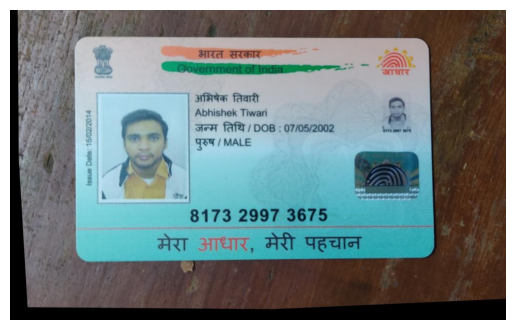

In [5]:

# Load the image
# img = cv2.imread("data\\01_raw_data\\bibek_pan.jpg")
img = cv2.imread("data\\01_raw_data\\sample_image1.jpg")

# displaying image using matplotlib
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

contours (133, 55, 743, 465)
Area 335355.0


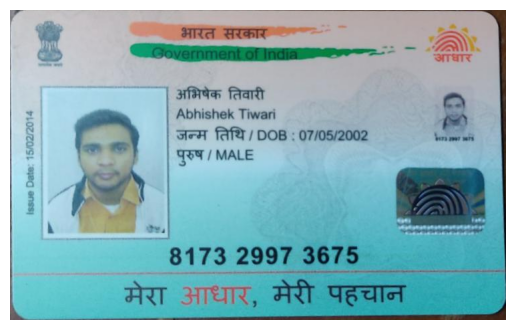

In [6]:
gray_img =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred =  cv2.GaussianBlur(gray_img, (3, 3), 0)
adp_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 2)

contours, _ = cv2.findContours(adp_thresh, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour (assuming the ID card is the largest object)
largest_contour = None
largest_area = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > largest_area:
        largest_contour = cnt
        largest_area = area

x, y, w, h = cv2.boundingRect(largest_contour)

print("contours", (x, y, w, h))
print("Area", largest_area)
contour_id = rgb_img[y:y+h, x:x+w]

plt.imshow(contour_id)
plt.axis('off')
plt.show()

In [7]:
cv2.imwrite("data\\02_intermediate_data\contour_id.jpg", cv2.cvtColor(contour_id, cv2.COLOR_RGB2BGR))

True

In [8]:
gray_contour_id =  cv2.cvtColor(contour_id, cv2.COLOR_RGB2GRAY)


In [9]:
# Check if the image was loaded successfully
# if img is None:
#     print(f"Error: Unable to load image at")
# else:
#     # Convert the image to grayscale for better OCR results
#     gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
#     # Apply thresholding to preprocess the image
#     # cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU can be replaced with other methods depending on the image
#     # _, threshold_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     # plt.imshow(threshold_img, cmap = 'gray')
#     # plt.show()

#     # Extract the text from the preprocessed image
#     # psm 6 stands for assuming a single uniform block of text.
#     custom_config = r'--oem 3 --psm 3 -l eng+osd --tessdata-dir "C:\\Program Files\\Tesseract-OCR\\tessdata" -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
#     text = pytesseract.image_to_string(gray_img, config=custom_config)
    
#     # Print the extracted text to the console
#     print(text)

`Tesseract Configuration (custom_config)`

--oem 3: Sets the OCR Engine Mode to 3, which means Tesseract will use both its LSTM and legacy engines to process the image. This is typically used to get the most accurate results.

--psm 3: Sets the Page Segmentation Mode to 3, indicating that Tesseract should treat the image as a single uniform block of text. This mode assumes a single column of text of variable sizes.

-l eng+osd: Specifies the language models to be used. Here, eng is for English, and osd is for orientation and script detection, which helps in determining text direction.

--tessdata-dir "C:\\Program Files\\Tesseract-OCR\\tessdata": Directs Tesseract to use a specific directory for its training data files. This is useful when you have custom training data or multiple versions of tessdata.

-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789: This restricts the characters Tesseract will recognize to alphanumeric characters (both upper and lower case). This is useful for filtering out any symbols or punctuation marks that are not needed.

In [10]:
custom_config = r'--oem 3 --psm 3 -l eng+osd --tessdata-dir "C:\\Program Files\\Tesseract-OCR\\tessdata" -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
text = pytesseract.image_to_string(gray_contour_id, config=custom_config)

print(text)

FNAAaT

arfrtayferargt
AbhishekTiwari
SteatfefDOB07052002

lon Ge4MALE

AZ

a

817329973675




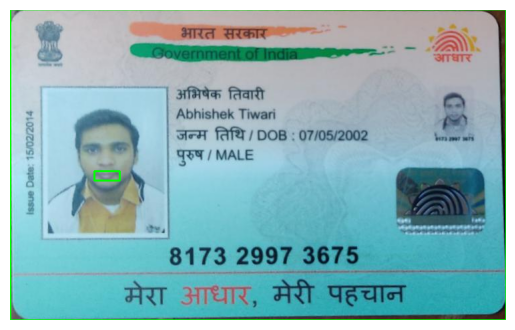

In [11]:
# Use pytesseract to detect text and its bounding boxes
data = pytesseract.image_to_data(gray_contour_id, config=custom_config, output_type=pytesseract.Output.DICT)

# Iterate through each detected text item
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 60:  # Only consider boxes with a confidence > 60
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        cv2.rectangle(contour_id, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw rectangle with green color and 2 px thickness

# Display the image with bounding boxes
plt.imshow(contour_id)
plt.axis('off')
plt.show()

In [12]:
# data['text']

### OCR using PaddleOCR

Due to its high accuracy and good speed, CRNN is an optimal choice for OCR. Latest libraries like Easy-ocr, Keras-ocr and PaddleOCR are based on CRNN and provide easy-to-use pretrained models. 

PaddleOCR supports more than 80 languages (depending upon the OCR algorithm used). But the flagship PP-OCR provides support for both Chinese and English languages. The flagship OCR algorithm PP-OCR is one of the best OCR tools available. So far, It has three versions as of now PP-OCR, PP-OCRv2 and PP-OCRv3. All of these models are built on CRNN as seen in the previous section and are ultra-lightweight. Let’s take a look and apply it to some of the various types of scenarios. 

`PaddleOCR Initialization Parameters`

use_angle_cls=True: This parameter tells PaddleOCR to use angle classification, which is useful when the text in the images could be oriented in different directions. With use_angle_cls set to True, the model will attempt to correct the orientation of the text before recognizing it, which generally improves the accuracy of text recognition.

use_gpu=False: This parameter specifies whether to use a GPU for processing. Setting use_gpu=False forces the tool to use the CPU instead. Using the GPU can significantly speed up OCR processing, especially for large volumes of images or high-resolution images, but it requires a compatible GPU and proper configuration. Setting it to False is useful if you are running the software on a system without a GPU or you want to ensure compatibility without requiring GPU resources.

In [ ]:
from paddleocr import PaddleOCR, draw_ocr
ocr = PaddleOCR(use_angle_cls=True, use_gpu=False)
def show_ocr(ocr, img_path, font):

    result = ocr.ocr(img_path)
    # save_path = os.path.join(out_path, img_path.split('/')[-1] + 'output')

    image = cv2.imread(img_path)

    boxes = [line[0] for line in result[0]]
    txts = [line[1][0] for line in result[0]]
    scores = [line[1][1] for line in result[0]]

    im_show = draw_ocr(image, boxes, txts, scores, font_path=font)

    # cv2.imwrite(save_path, im_show)

    img = cv2.cvtColor(im_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img)	
    plt.axis('off')
    # return result

[2024/04/28 12:18:08] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.10768461227416992


[2024/04/28 12:18:09] ppocr DEBUG: cls num  : 15, elapsed : 0.0500185489654541
[2024/04/28 12:18:09] ppocr DEBUG: rec_res num  : 15, elapsed : 0.5003061294555664


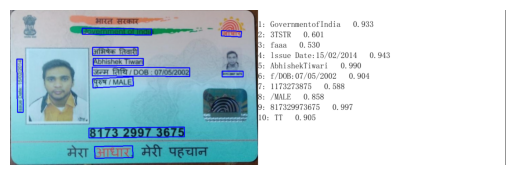

In [ ]:
img_path = "data\\02_intermediate_data\\contour_id.jpg"
font = "data\\01_raw_data\\simfang.ttf"
show_ocr(ocr, img_path, font)

### Keras OCR

In [16]:
import keras_ocr
import matplotlib.pyplot as plt

In [17]:
pipeline = keras_ocr.pipeline.Pipeline()
# Read images from folder path to image object
images = [
    keras_ocr.tools.read(img) for img in ['data\\01_raw_data\\pan_2.jpg',
                                          'data\\01_raw_data\\pan_3.webp',]
]

Looking for C:\Users\rauth\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\rauth\.keras-ocr\crnn_kurapan.h5


2/2 [==============================] - 5s 788ms/step


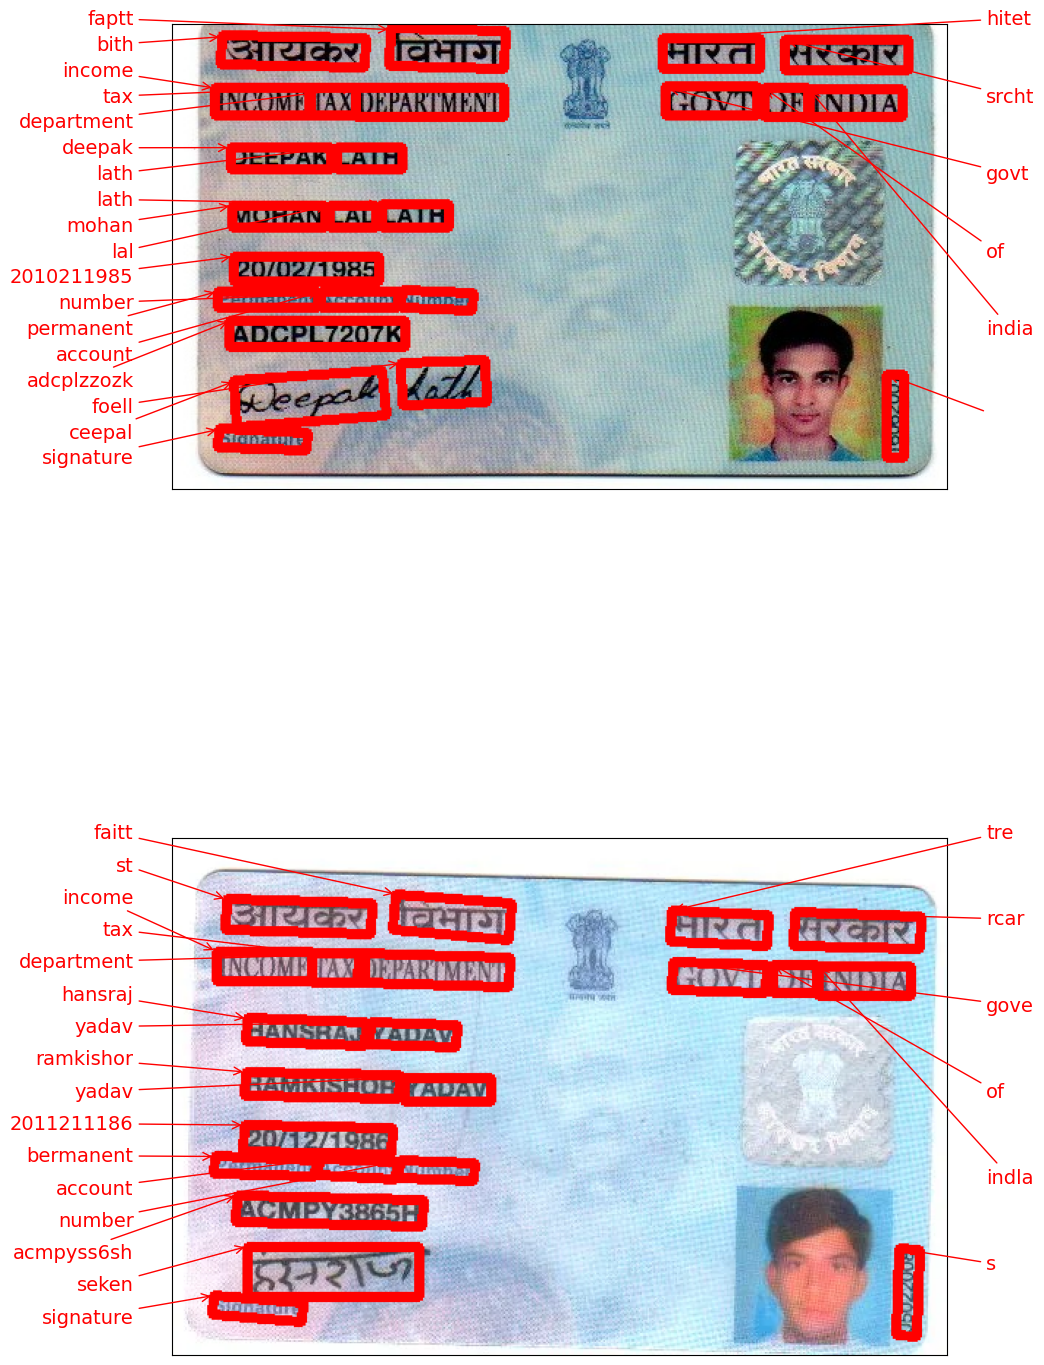

In [18]:
# generate text predictions from the images
prediction_groups = pipeline.recognize(images)

# plot the text predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(10, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

### Using easyOCR

In [19]:
import easyocr

In [21]:
img_path = 'data\\02_intermediate_data\\contour_id.jpg'
reader = easyocr.Reader(['en'])
result = reader.readtext(img_path)
confidence_threshold =  .80
filtered_text = ""  # Initialize an empty string to store filtered text
for text in result:
    bounding_box, recognized_text, confidence = text
    if confidence > confidence_threshold:
        filtered_text += recognized_text + "|"  # Append filtered text with newline

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [22]:
filtered_text

'Abhishek Tiwari|DOB|07/05/2002|MALE|8|'